/tmp/ipykernel_82/3445354403.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['GENERATION', 'SEX', 'AGE']).apply(weighted_mean).reset_index()


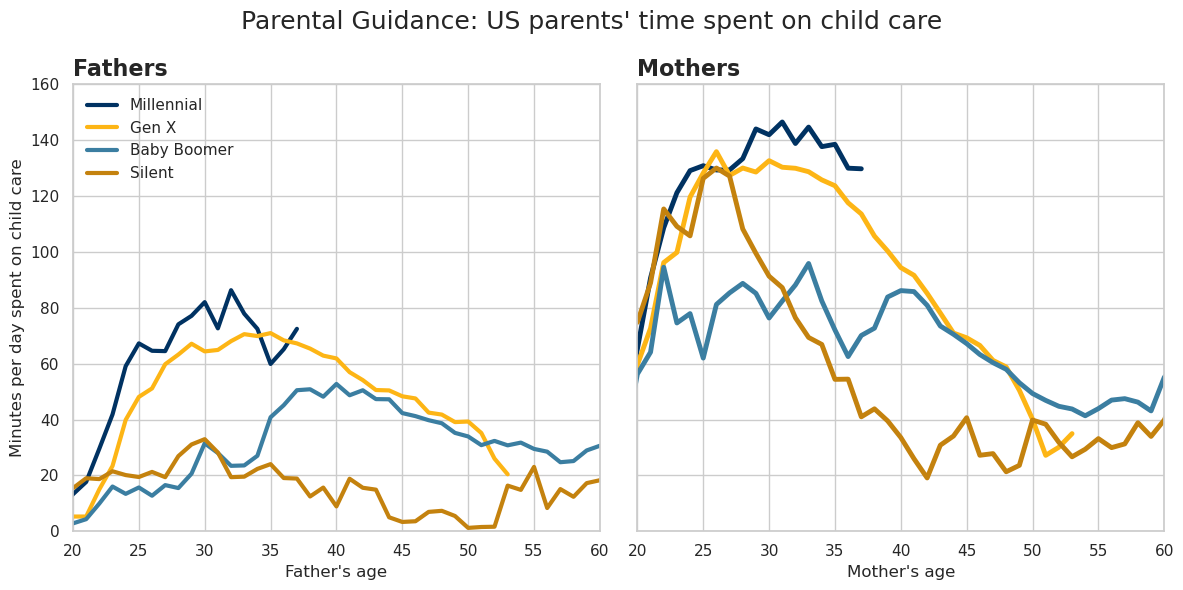

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: LOAD THE DATA ---
# Loading the file you provided
df = pd.read_csv('ahtus_00002.csv.gz')

# --- STEP 2: DEFINE GENERATIONS ---
# Calculate Birth Year
df['BIRTH_YEAR'] = df['YEAR'] - df['AGE']

def get_generation(birth_year):
    if 1981 <= birth_year <= 1996:
        return 'Millennial'
    elif 1965 <= birth_year <= 1980:
        return 'Gen X'
    elif 1946 <= birth_year <= 1964:
        return 'Baby Boomer'
    elif 1928 <= birth_year <= 1945:
        return 'Silent'
    else:
        return 'Other'

df['GENERATION'] = df['BIRTH_YEAR'].apply(get_generation)

# --- STEP 3: FILTER THE DATA ---
# Filter 1: Parents (Using 'UNDER18' >= 1)
# This keeps households with at least one person under 18.
df = df[df['UNDER18'] >= 1] 

# Filter 2: Partner Present (Using EMPSP < 90)
# Codes < 90 mean "Employed" or "Unemployed" (spouse exists). 
# 99 means "Not in Universe" (no spouse).
df = df[df['EMPSP'] < 90] 

# Filter 3: Drop "Other" generations to clean up the legend
df = df[df['GENERATION'] != 'Other']

# --- STEP 4: CALCULATE WEIGHTED AVERAGES ---
def weighted_mean(x):
    # Safety check: avoid dividing by zero if weights sum to 0
    if x['RECWGHT'].sum() <= 0:
        return np.nan
    return np.average(x['ACT_CHCARE'], weights=x['RECWGHT'])

# Group by Generation, Sex (1=Male, 2=Female), and Age
grouped = df.groupby(['GENERATION', 'SEX', 'AGE']).apply(weighted_mean).reset_index()
grouped.columns = ['GENERATION', 'SEX', 'AGE', 'AVG_MINUTES']

# --- STEP 5: SMOOTHING---
#  use window=3 to smooth the lines.
grouped['AVG_MINUTES_SMOOTH'] = grouped.groupby(['GENERATION', 'SEX'])['AVG_MINUTES'] \
                                       .transform(lambda x: x.rolling(window=3, min_periods=1, center=True).mean())

# --- STEP 6: PLOTTING ---
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Professional Academic / Berkeley-ish Theme
palette = {
    'Millennial':  '#003262',  # Berkeley Blue (Dark Navy)
    'Gen X':       '#FDB515',  # California Gold (Marigold)
    'Baby Boomer': '#3B7EA1',  # Founder's Rock (Light Blue)
    'Silent':      '#C4820E'   # Darker Gold
}
hue_order = ['Millennial', 'Gen X', 'Baby Boomer', 'Silent']

# Plot Fathers (SEX = 1)
sns.lineplot(
    data=grouped[grouped['SEX'] == 1], 
    x='AGE', y='AVG_MINUTES_SMOOTH', hue='GENERATION', hue_order=hue_order,
    palette=palette, ax=axes[0], linewidth=3
)
axes[0].set_title("Fathers", fontsize=16, loc='left', fontweight='bold')
axes[0].set_ylabel("Minutes per day spent on child care")
axes[0].set_xlabel("Father's age")
axes[0].set_xlim(20, 60)
axes[0].set_ylim(0, 160)
axes[0].legend(title=None, frameon=False, loc='upper left')

# Plot Mothers (SEX = 2)
sns.lineplot(
    data=grouped[grouped['SEX'] == 2], 
    x='AGE', y='AVG_MINUTES_SMOOTH', hue='GENERATION', hue_order=hue_order,
    palette=palette, ax=axes[1], linewidth=3.5
)
axes[1].set_title("Mothers", fontsize=16, loc='left', fontweight='bold')
axes[1].set_ylabel("") 
axes[1].set_xlabel("Mother's age")
axes[1].set_xlim(20, 60)
axes[1].get_legend().remove() # Hide legend on the second plot

plt.suptitle("Parental Guidance: US parents' time spent on child care", fontsize=18)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: LOAD THE DATA ---
# Loading the file you provided
df = pd.read_csv('ahtus_00002.csv.gz')

In [15]:
df

,SAMPLE,PERNUM,IDENT,HHID,PID,SERIAL,YEAR,AGE,SEX,RECWGHT,UNDER18,EMPSP,NCHILD,ACT_CHCARE
0,1930,1,10101,1.0,1,1,1931,42,2,NaN,NaN,3.0,1.0,45
1,1930,1,10102,1.0,1,2,1931,42,2,NaN,NaN,3.0,1.0,115
2,1930,1,10103,1.0,1,3,1931,42,2,NaN,NaN,3.0,1.0,30
3,1930,1,10104,1.0,1,4,1931,42,2,NaN,NaN,3.0,1.0,95
4,1930,1,10105,1.0,1,5,1931,42,2,NaN,NaN,3.0,1.0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169953,2018,1,95890101,NaN,20181212182342,9589,2018,69,2,0.357019,0.0,4.0,NaN,0
169954,2018,1,95900101,NaN,20181212182427,9590,2018,32,1,0.798979,0.0,-7.0,NaN,0
169955,2018,1,95910101,NaN,20181212182503,9591,2018,17,1,1.605176,2.0,-7.0,NaN,0
169956,2018,1,95920101,NaN,20181212182505,9592,2018,58,2,0.558359,0.0,-7.0,NaN,0
